In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
%matplotlib inline

In [2]:
conn=sqlite3.connect('database.sqlite')
filtered_data=pd.read_sql_query('''SELECT * FROM REVIEWS WHERE SCORE!=3''',conn)

In [3]:
filtered_data.Score=filtered_data.Score.apply(lambda x:'positive' if x>3 else 'negative')

In [4]:
sorted_values=filtered_data.sort_values('ProductId',axis=0,ascending=True)
final=sorted_values.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [5]:
final['Time']=pd.to_datetime(final['Time'])
final=final.sort_values(by='Time',ascending=True)
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1970-01-01 00:00:00.939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1970-01-01 00:00:00.940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1970-01-01 00:00:00.944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1970-01-01 00:00:00.944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,1970-01-01 00:00:00.946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


In [6]:
final=final.iloc[:60000,:]

In [7]:
final.Score=final.Score.apply(lambda x:1 if x=='positive' else 0)

In [8]:
final.shape

(60000, 10)

# Text Preprocessing


In [9]:
import nltk
import re
def clean_html(sent):
    clean_text=re.sub(r"[<*.?>]",' ',sent)
    return clean_text

def clean_punc(sent):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sent)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

In [10]:
from tqdm import tqdm
import os

final_string=[]
for i,sent in enumerate(tqdm(final.Text.values)):
    filtered_sentence=[]
    sent=clean_html(sent)
    for w in sent.split():
        for word in clean_punc(w).split():
            if ((word.isalpha())&(len(word)>2)):
                if word.lower() not in stop:
                    s=(sno.stem(word.lower())).encode('utf-8')
                    filtered_sentence.append(s)
    string=b' '.join(filtered_sentence)
    final_string.append(string)

final['Cleaned_Text']=final_string
final['Cleaned_Text']=final['Cleaned_Text'].str.decode('utf-8')

100%|██████████████████████████████████████████████████████████████████████████| 60000/60000 [00:46<00:00, 1282.08it/s]


# Time Based Splitting

In [42]:
from sklearn.model_selection import train_test_split
X_1,X_test,y_1,y_test=train_test_split(final.Cleaned_Text,final.Score,test_size=0.3,shuffle=None)
X_train,X_cv,y_train,y_cv=train_test_split(X_1,y_1,test_size=0.3,shuffle=None)


# Function to find Optimal K using KNN Brute Force Algo

In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def k_optimal_fun(X_train,y_train,X_cv,y_cv):
    neighbors=list(range(1,30,2))
    accuracy_list=[]
    for i in neighbors:
        classifier=KNeighborsClassifier(n_neighbors=i,algorithm='brute')
        classifier.fit(X_train,y_train)
        pred=classifier.predict(X_cv)
        accuracy=accuracy_score(y_cv,pred,normalize=True)*float(100)
        accuracy_list.append(accuracy)
    MSE=[1-x for x in accuracy_list]
    optimal_k=neighbors[MSE.index(min(MSE))]
    plt.plot(neighbors,MSE)
    xy = (optimal_k, min(MSE))
    plt.annotate('(%s, %s)' % xy,xy=xy,textcoords='data')
    plt.xlabel("Number of neighbours 'k'")
    plt.ylabel("Misclassification Error")
    plt.show()    
    return optimal_k

# Bag of Words Model


In [45]:
from sklearn.feature_extraction.text import CountVectorizer
cv_bow=CountVectorizer()
bow_X_1=cv_bow.fit_transform(X_1.values)
bow_X_test=cv_bow.transform(X_test.values)
cv_bow2=CountVectorizer()
bow_X_train=cv_bow2.fit_transform(X_train.values)
bow_X_cv=cv_bow2.transform(X_cv.values)

from sklearn.preprocessing import StandardScaler
sc1=StandardScaler(with_mean=False)
sc2=StandardScaler(with_mean=False)
bow_X_1=sc1.fit_transform(bow_X_1)
bow_X_test=sc1.transform(bow_X_test)
bow_X_train=sc2.fit_transform(bow_X_train)
bow_X_cv=sc2.transform(bow_X_cv)

C:\Users\SKS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\SKS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\SKS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\SKS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\SKS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float6

In [48]:
bow_X_train.shape

(29400, 21243)

In [50]:
y_test.shape

(18000,)

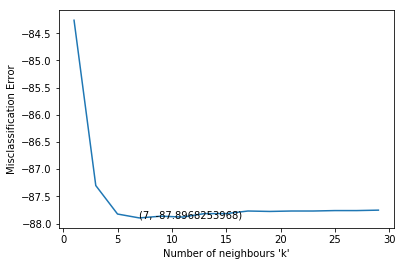

In [53]:
optimal_k=k_optimal_fun(bow_X_train,y_train,bow_X_cv,y_cv)

In [54]:
optimal_k

7

In [63]:
classfier_opt=KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')
classfier_opt.fit(bow_X_1,y_1)
pred=classfier_opt.predict(bow_X_test)
accuracy_brute_bow=accuracy_score(y_test,pred)*100
accuracy_brute_bow

89.011111111111106

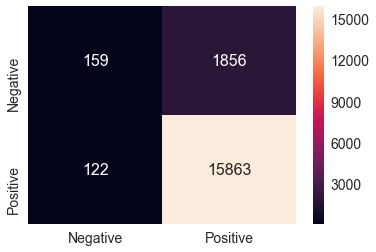

In [65]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_test,pred), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [56]:
from sklearn.feature_extraction.text import CountVectorizer
cv_bow=CountVectorizer(max_features=500)
bow_X_1=cv_bow.fit_transform(X_1.values)
bow_X_test=cv_bow.transform(X_test.values)

sc1=StandardScaler(with_mean=False)
bow_X_1=sc1.fit_transform(bow_X_1)
bow_X_test=sc1.transform(bow_X_test)


C:\Users\SKS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\SKS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\SKS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [58]:
classfier_opt=KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
classfier_opt.fit(bow_X_1.todense(),y_1)
pred=classfier_opt.predict(bow_X_test.todense())
accuracy_kdtree_bow=accuracy_score(y_test,pred)*100
accuracy_kdtree_bow

89.011111111111106

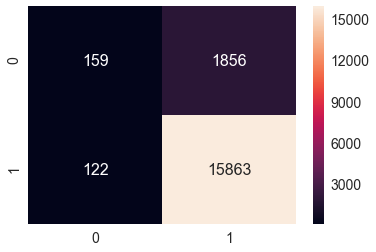

In [62]:
df_cm = pd.DataFrame(confusion_matrix(y_test,pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Optimal K
* By using simple cross validation we get optimal k=7

## Brute Force Algorithm
* Accuracy of Test Set with K=7 on brute force algorith is 89.01%

## KdTree Algorithm
* Accuracy of Test Set with K=7 on kd_tree algorithm is 89.01%



# TF-IDF Model

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
tfidf_vect=TfidfVectorizer(ngram_range=(1,2))
tfidf_X_1=tfidf_vect.fit_transform(X_1.values)
tfidf_X_test=tfidf_vect.transform(X_test.values)
tfidf_vect2=TfidfVectorizer(ngram_range=(1,2))
tfidf_X_train=tfidf_vect2.fit_transform(X_train.values)
tfidf_X_cv=tfidf_vect2.transform(X_cv.values)

from sklearn.preprocessing import StandardScaler

sc1=StandardScaler(with_mean=False)
sc2=StandardScaler(with_mean=False)
tfidf_X_1=sc1.fit_transform(tfidf_X_1)
tfidf_X_test=sc1.transform(tfidf_X_test)
tfidf_X_train=sc2.fit_transform(tfidf_X_train)
tfidf_X_cv=sc2.transform(tfidf_X_cv)

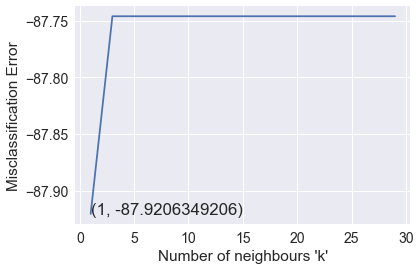

1

In [67]:
optimal_k=k_optimal_fun(tfidf_X_train,y_train,tfidf_X_cv,y_cv)
optimal_k

In [68]:
classfier_opt=KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')
classfier_opt.fit(tfidf_X_1,y_1)
pred=classfier_opt.predict(tfidf_X_test)
accuracy_brute_tfidf=accuracy_score(y_test,pred)*100
accuracy_brute_tfidf

88.927777777777777

Text(0.5,1,'Confusion Matrix')

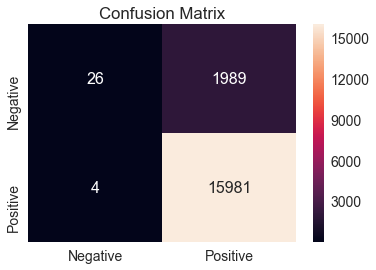

In [69]:
df_cm = pd.DataFrame(confusion_matrix(y_test,pred), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
tfidf_vect=TfidfVectorizer(ngram_range=(1,2),max_features=500,min_df=50)
tfidf_X_1=tfidf_vect.fit_transform(X_1.values)
tfidf_X_test=tfidf_vect.transform(X_test.values)

sc1=StandardScaler(with_mean=False)
tfidf_X_1=sc1.fit_transform(tfidf_X_1)
tfidf_X_test=sc1.transform(tfidf_X_test)


In [71]:
classfier_opt=KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
classfier_opt.fit(tfidf_X_1.todense(),y_1)
pred=classfier_opt.predict(tfidf_X_test.todense())
accuracy_kdtree_tfidf=accuracy_score(y_test,pred)*100
accuracy_kdtree_tfidf

86.37222222222222

Text(0.5,1,'Confusion Matrix')

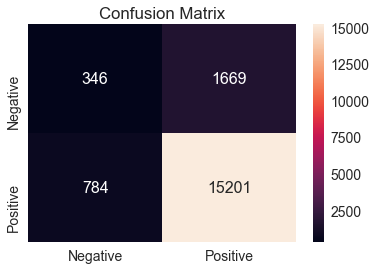

In [72]:
df_cm = pd.DataFrame(confusion_matrix(y_test,pred), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

## Optimal K
* By using simple cross validation we get optimal k=1

## Brute Force Algorithm
* Accuracy of Test Set with K=1 on brute force algorith is 88.92%

## KdTree Algorithm
* Accuracy of Test Set with K=1 on kd_tree algorithm is 86.37%


# Average Word2Vec Model

In [73]:
from gensim.models import Word2Vec
list_of_sent_X_1=[]
for sent in X_1.values:
    list_of_sent_X_1.append(sent.split())
    
w2v_model_X_1=Word2Vec(list_of_sent_X_1,min_count=5,size=50, workers=4)
w2v_words_X_1 = list(w2v_model_X_1.wv.vocab)

avg_w2v_sent_vector_X_1=[]
for sent in tqdm(list_of_sent_X_1):
    sent_vec=np.zeros(50)
    c=0
    for word in sent:
        if word in w2v_words_X_1:
            vec=w2v_model_X_1.wv[word]
            sent_vec +=vec
            c=c+1
    if c!=0:
        sent_vec /=c
    avg_w2v_sent_vector_X_1.append(sent_vec)
    
list_of_sent_test=[]
for sent in X_test.values:
    list_of_sent_test.append(sent.split())
    

avg_w2v_sent_vector_test=[]
for sent in tqdm(list_of_sent_test):
    sent_vec=np.zeros(50)
    c=0
    for word in sent:
        if word in w2v_words_X_1:
            vec=w2v_model_X_1.wv[word]
            sent_vec +=vec
            c=c+1
    if c!=0:
        sent_vec /=c
    avg_w2v_sent_vector_test.append(sent_vec)
    
list_of_sent_train=[]
for sent in X_train.values:
    list_of_sent_train.append(sent.split())
    
w2v_model_train=Word2Vec(list_of_sent_train,min_count=5,size=50, workers=4)
w2v_words_train = list(w2v_model_train.wv.vocab)

avg_w2v_sent_vector_train=[]
for sent in tqdm(list_of_sent_train):
    sent_vec=np.zeros(50)
    c=0
    for word in sent:
        if word in w2v_words_train:
            vec=w2v_model_train.wv[word]
            sent_vec +=vec
            c=c+1
    if c!=0:
        sent_vec /=c
    avg_w2v_sent_vector_train.append(sent_vec)
    

list_of_sent_cv=[]
for sent in X_cv.values:
    list_of_sent_cv.append(sent.split())
    


avg_w2v_sent_vector_cv=[]
for sent in tqdm(list_of_sent_cv):
    sent_vec=np.zeros(50)
    c=0
    for word in sent:
        if word in w2v_words_train:
            vec=w2v_model_train.wv[word]
            sent_vec +=vec
            c=c+1
    if c!=0:
        sent_vec /=c
    avg_w2v_sent_vector_cv.append(sent_vec)

sc1=StandardScaler(with_mean=False)
sc2=StandardScaler(with_mean=False)

avg_w2v_sent_vector_X_1=sc1.fit_transform(avg_w2v_sent_vector_X_1)
avg_w2v_sent_vector_test=sc1.transform(avg_w2v_sent_vector_test)
avg_w2v_sent_vector_train=sc2.fit_transform(avg_w2v_sent_vector_train)
avg_w2v_sent_vector_cv=sc2.transform(avg_w2v_sent_vector_cv)

C:\Users\SKS\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
100%|██████████████████████████████████████████████████████████████████████████| 12600/12600 [00:10<00:00, 1192.12it/s]


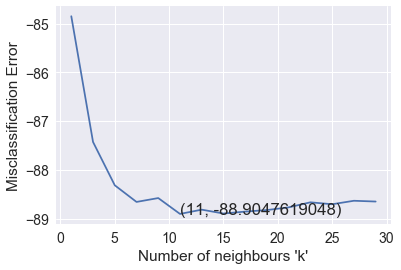

11

In [74]:
optimal_k=k_optimal_fun(avg_w2v_sent_vector_train,y_train,avg_w2v_sent_vector_cv,y_cv)
optimal_k


In [75]:
classfier_opt=KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')
classfier_opt.fit(avg_w2v_sent_vector_X_1,y_1)
pred=classfier_opt.predict(avg_w2v_sent_vector_test)
accuracy_brute_avg_w2v=accuracy_score(y_test,pred)*100
accuracy_brute_avg_w2v

89.849999999999994

Text(0.5,1,'Confusion Matrix')

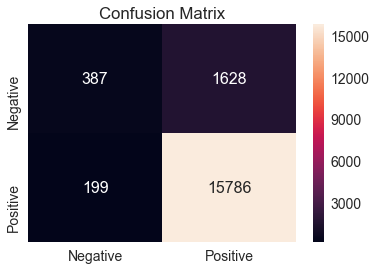

In [76]:
df_cm = pd.DataFrame(confusion_matrix(y_test,pred), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [77]:
classfier_opt=KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
classfier_opt.fit(avg_w2v_sent_vector_X_1,y_1)
pred=classfier_opt.predict(avg_w2v_sent_vector_test)
accuracy_kdtree_avg_w2v=accuracy_score(y_test,pred)*100
accuracy_kdtree_avg_w2v

89.849999999999994

Text(0.5,1,'Confusion Matrix')

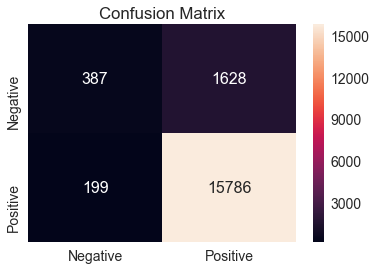

In [78]:
df_cm = pd.DataFrame(confusion_matrix(y_test,pred), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

## Optimal K
* By using simple cross validation we get optimal k=11

## Brute Force Algorithm
* Accuracy of Test Set with K=11 on brute force algorith is 89.84%

## KdTree Algorithm
* Accuracy of Test Set with K=11 on kd_tree algorithm is 89.84%


# TFIDF Word2Vec Model

In [79]:
model1 = TfidfVectorizer()
tf_idf_matrix = model1.fit_transform(X_1.values)

dictionary = dict(zip(model1.get_feature_names(), list(model1.idf_)))

tfidf_feat = model1.get_feature_names() 
tfidf_sent_vectors_X_1 = []
for sent in tqdm(list_of_sent_X_1): 
    sent_vec = np.zeros(50)
    weight_sum =0; 
    for word in sent: 
        if (word in w2v_words_X_1):
            vec = w2v_model_X_1.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_X_1.append(sent_vec)

100%|███████████████████████████████████████████████████████████████████████████| 42000/42000 [00:47<00:00, 885.89it/s]


In [81]:
tf_idf_matrix = model1.transform(X_test.values)

dictionary = dict(zip(model1.get_feature_names(), list(model1.idf_)))

tfidf_feat = model1.get_feature_names() 
tfidf_sent_vectors_test = []
for sent in tqdm(list_of_sent_test): 
    sent_vec = np.zeros(50)
    weight_sum =0; 
    for word in sent: 
        if (word in w2v_words_X_1):
            vec = w2v_model_X_1.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)

100%|███████████████████████████████████████████████████████████████████████████| 18000/18000 [00:19<00:00, 900.06it/s]


In [82]:
model3 = TfidfVectorizer()
tf_idf_matrix = model3.fit_transform(X_train.values)

dictionary = dict(zip(model3.get_feature_names(), list(model3.idf_)))

tfidf_feat = model3.get_feature_names() 
tfidf_sent_vectors_train = []
for sent in tqdm(list_of_sent_train): 
    sent_vec = np.zeros(50)
    weight_sum =0; 
    for word in sent: 
        if (word in w2v_words_train):
            vec = w2v_model_train.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)

100%|██████████████████████████████████████████████████████████████████████████| 29400/29400 [00:28<00:00, 1034.78it/s]


In [83]:

tf_idf_matrix = model3.fit_transform(X_cv.values)

dictionary = dict(zip(model3.get_feature_names(), list(model3.idf_)))

tfidf_feat = model3.get_feature_names() 
tfidf_sent_vectors_cv = []
for sent in tqdm(list_of_sent_cv): 
    sent_vec = np.zeros(50)
    weight_sum =0; 
    for word in sent: 
        if (word in w2v_words_train):
            vec = w2v_model_train.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)

100%|██████████████████████████████████████████████████████████████████████████| 12600/12600 [00:12<00:00, 1026.72it/s]


In [84]:
sc1=StandardScaler(with_mean=False)
sc2=StandardScaler(with_mean=False)

tfidf_sent_vectors_X_1=sc1.fit_transform(tfidf_sent_vectors_X_1)
tfidf_sent_vectors_test=sc1.transform(tfidf_sent_vectors_test)
tfidf_sent_vectors_train=sc2.fit_transform(tfidf_sent_vectors_train)
tfidf_sent_vectors_cv=sc2.transform(tfidf_sent_vectors_cv)

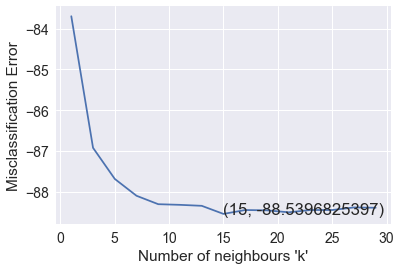

15

In [85]:
optimal_k=k_optimal_fun(tfidf_sent_vectors_train,y_train,tfidf_sent_vectors_cv,y_cv)
optimal_k

In [86]:
classfier_opt=KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')
classfier_opt.fit(tfidf_sent_vectors_X_1,y_1)
pred=classfier_opt.predict(tfidf_sent_vectors_test)
accuracy_brute_tfidf_w2v=accuracy_score(y_test,pred)*100
accuracy_brute_tfidf_w2v

89.566666666666677

Text(0.5,1,'Confusion Matrix')

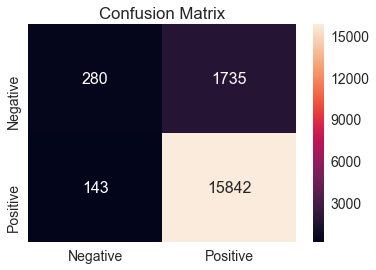

In [87]:
df_cm = pd.DataFrame(confusion_matrix(y_test,pred), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [91]:
classfier_opt=KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
classfier_opt.fit(tfidf_sent_vectors_X_1,y_1)
pred=classfier_opt.predict(tfidf_sent_vectors_test)
accuracy_kdtree_tfidf_w2v=accuracy_score(y_test,pred)*100
accuracy_kdtree_tfidf_w2v

89.566666666666677

Text(0.5,1,'Confusion Matrix')

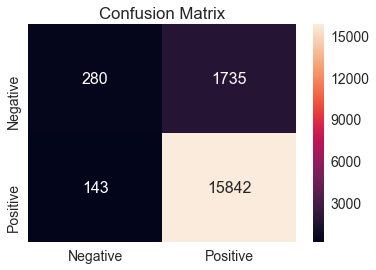

In [92]:
df_cm = pd.DataFrame(confusion_matrix(y_test,pred), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

## Optimal K
* By using simple cross validation we get optimal k=15

## Brute Force Algorithm
* Accuracy of Test Set with K=15 on brute force algorith is 89.56%

## KdTree Algorithm
* Accuracy of Test Set with K=15 on kd_tree algorithm is 89.56%



# Conclusion
* Avg Word2Vec works best on Amazon food Reviews Dataset wth 89.84% accuracy on Test data
* KD_Tree Algorithm is not good for higher dimensions so we have to reduce dimensions and in this way we are loosing some information while using KD_Tree Algorithm
